In [1]:
%pip install git+https://github.com/peng-lab/basicpy@dev

  Cloning https://github.com/peng-lab/basicpy (to revision dev) to /private/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/pip-req-build-7rhi53q5
  Running command git clone --filter=blob:none --quiet https://github.com/peng-lab/basicpy /private/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/pip-req-build-7rhi53q5
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/peng-lab/basicpy to commit 166bf6190c1827b5a5ece4a5542433c96a2bc997
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import basicpy
from matplotlib import pyplot as plt
from os import path
from scipy.ndimage import affine_transform
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
from skimage.transform import rescale
from pathlib import Path
from tqdm import tqdm

plt.rcParams["font.family"] = "sans-serif"
import os

os.makedirs("plots", exist_ok=True)

In [3]:
basedir = Path(
    "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/TimmSchroeder/raw_images/230517GC16_p0001"
)
basedir = Path("raw_images/230517GC16_p0001")
!ls "$basedir/z001_w00.npz"

raw_images/230517GC16_p0001/z001_w00.npz


[1]


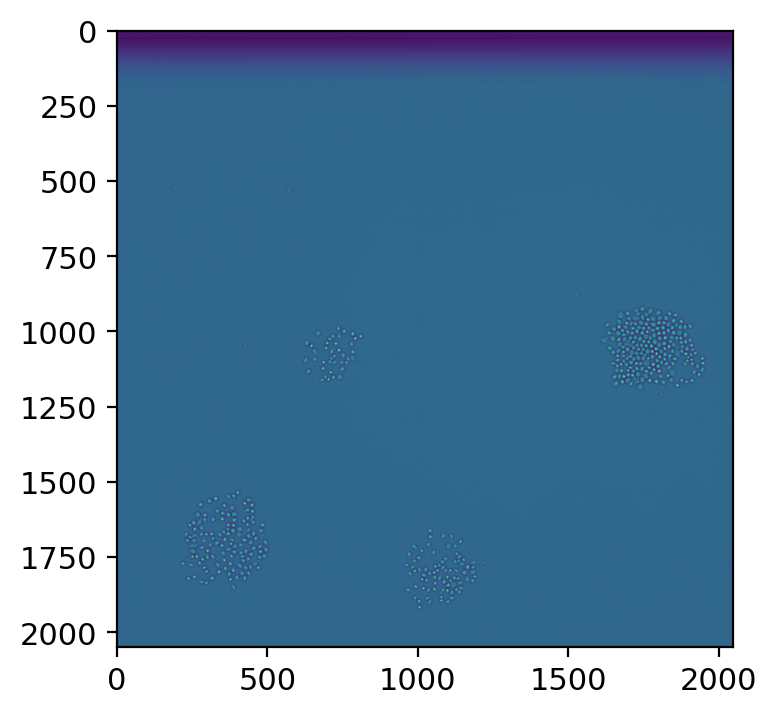

[8]


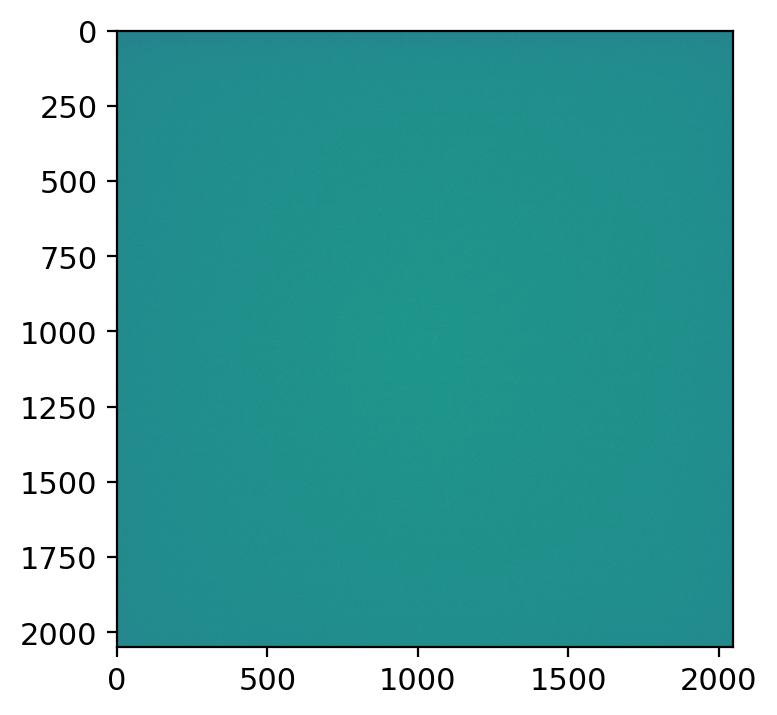

[8]


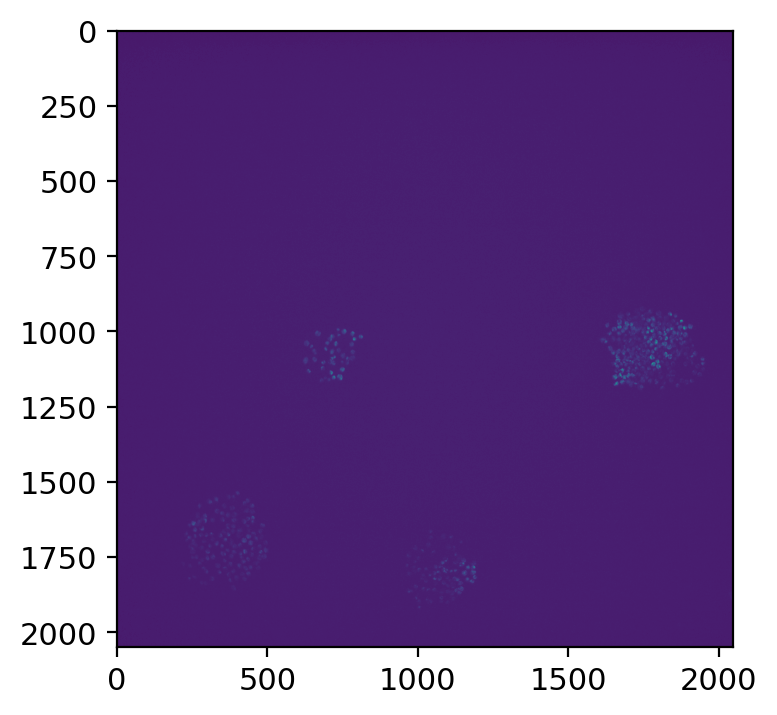

[8]


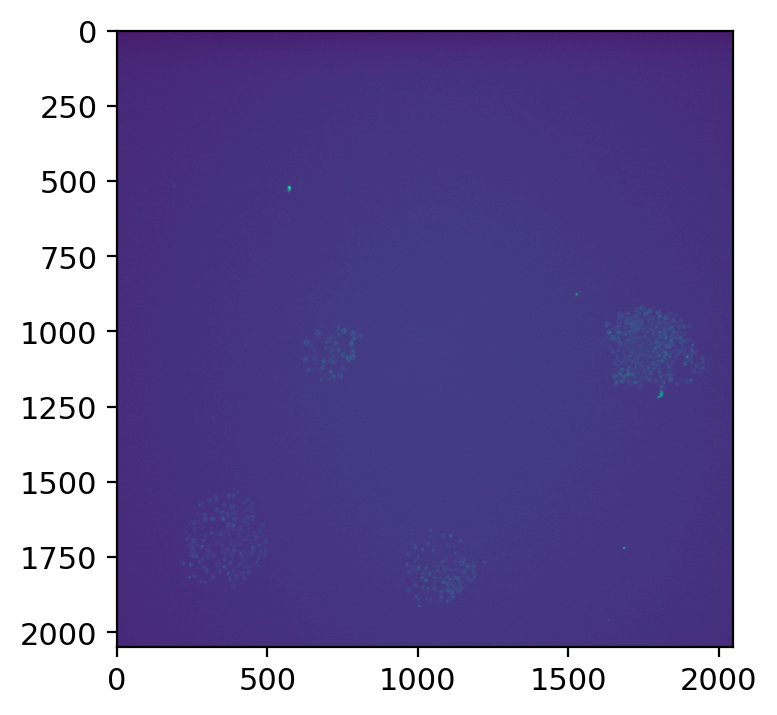

[8]


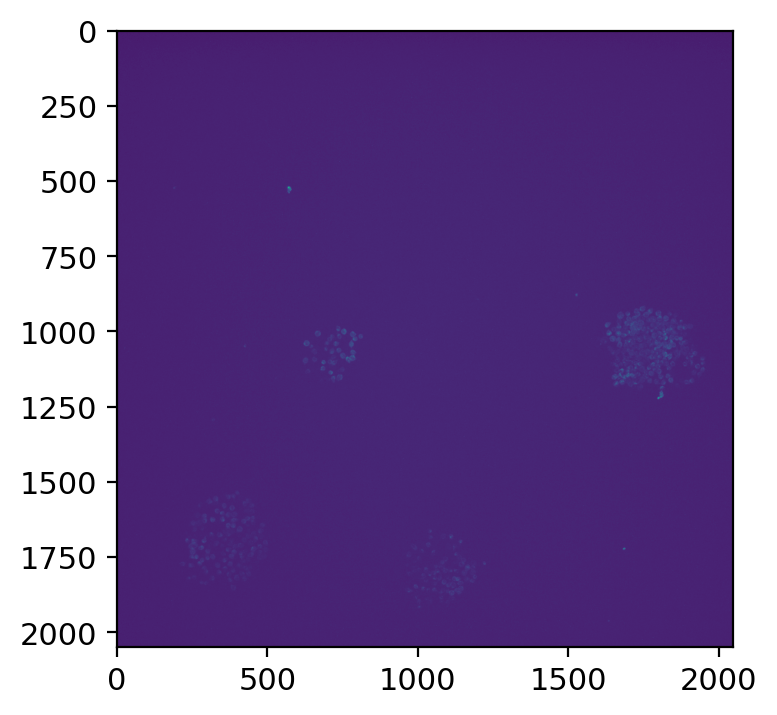

[8]


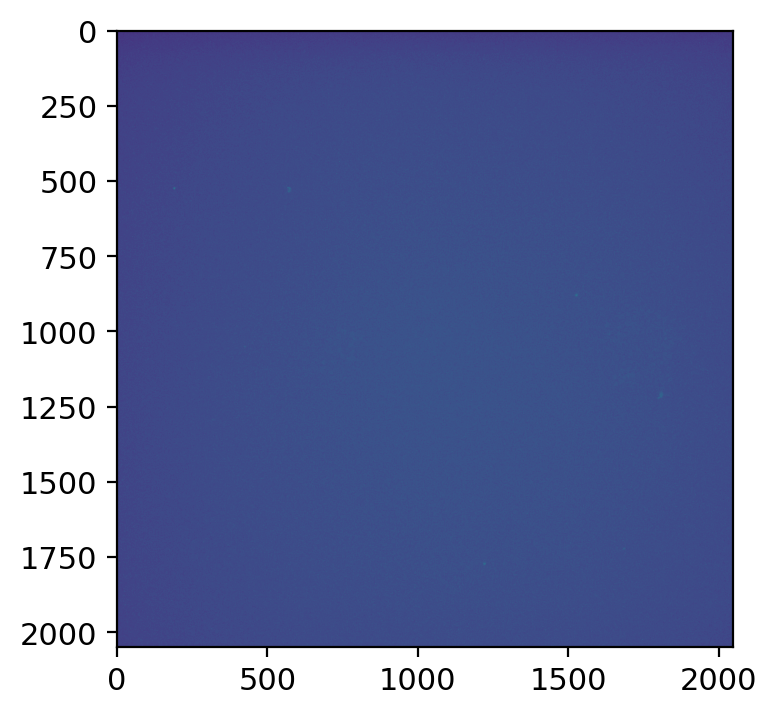

In [6]:
for channel in range(6):
    f = np.load(path.join(basedir, f"z001_w{channel:02d}.npz"))
    times = f["times"]
    print(np.unique(times[1:] - times[:-1]))
    image = f["images"][-1]
    plt.imshow(image)
    plt.show()

In [7]:
channel = 0
f = np.load(path.join(basedir, f"z001_w{channel:02d}.npz"))
images_bf = f["images"][:]
times_bf = f["times"][:]

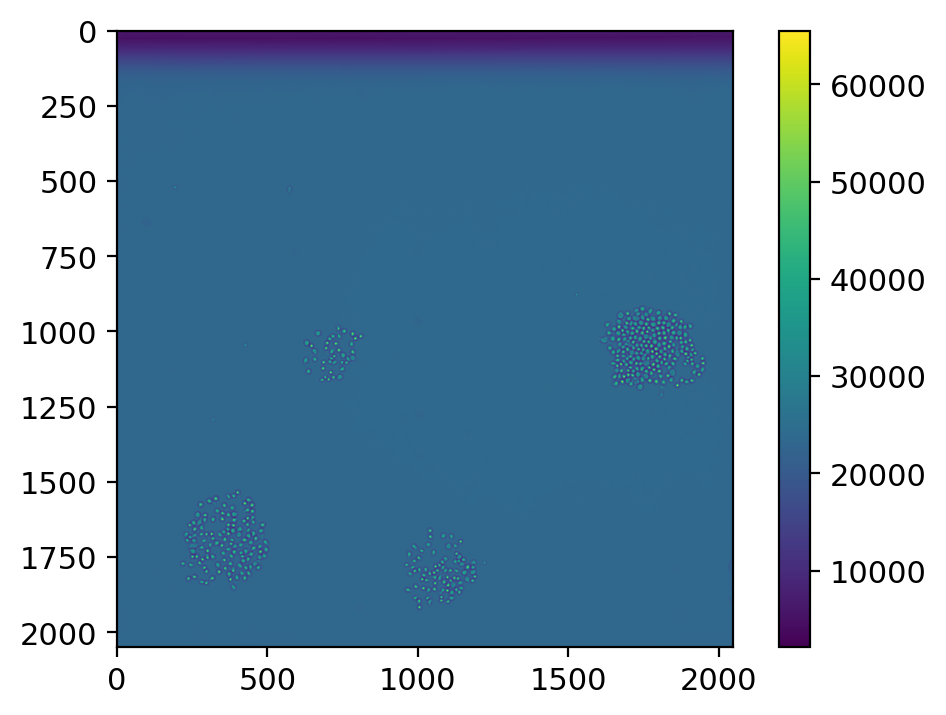

In [8]:
plt.imshow(images_bf[-1])
plt.colorbar()

(-0.5, 2047.5, 2047.5, -0.5)

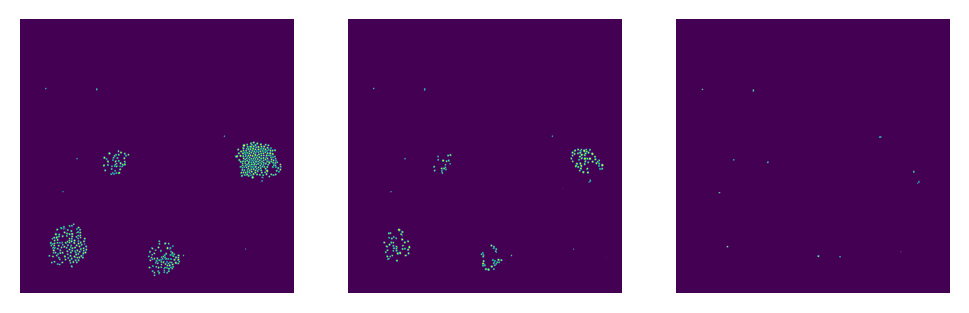

In [9]:
th = np.quantile(images_bf[-1], 0.99)


def to_mask(im):
    m = im > th
    return binary_dilation(m, disk(1))


plt.subplot(131)
plt.imshow(to_mask(images_bf[-1]))
plt.axis("off")
plt.subplot(132)
plt.imshow(to_mask(images_bf[-50]))
plt.axis("off")
plt.subplot(133)
plt.imshow(to_mask(images_bf[0]))
plt.axis("off")

In [10]:
masks = np.array([to_mask(im) for im in tqdm(images_bf)])
np.savez(
    path.join(basedir, f"z001_w{channel:02d}_mask.npz"), times=times_bf, masks=masks
)

100%|██████████| 241/241 [00:20<00:00, 11.61it/s]


In [11]:
channel = 3
f = np.load(path.join(basedir, f"z001_w{channel:02d}.npz"))
images = f["images"][:]
times = f["times"][:]
f = np.load(path.join(basedir, f"z001_w00_mask.npz"))
times_masks = list(f["times"][:])
index = [times_masks.index(t) for t in times]
masks = f["masks"][index]

In [12]:
images.shape, masks.shape

((31, 2048, 2048), (31, 2048, 2048))

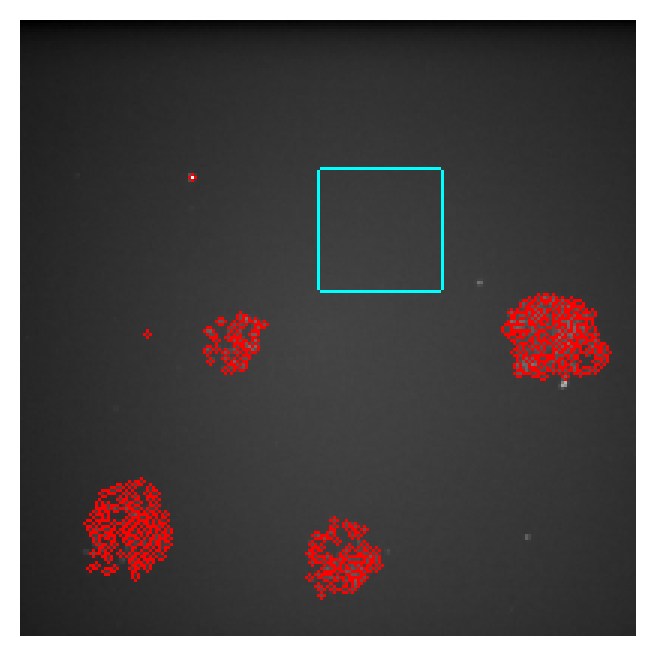

In [29]:
scale = 0.1


def show_image(im0, m0, rect):
    im0 = rescale(im0, scale)
    m0 = rescale(m0, scale, anti_aliasing=False)
    r0 = rescale(rect, scale, anti_aliasing=False)
    im0 = (im0 - im0.min()) / (im0.max() - im0.min())
    im0 = im0[..., np.newaxis] * np.array([1, 1, 1])
    mask_border = np.logical_xor(m0, binary_dilation(m0, disk(1)))
    rect_border = np.logical_xor(r0, binary_dilation(r0, disk(1)))
    im0[mask_border] = [1, 0, 0]
    im0[rect_border] = [0, 1, 1]
    return im0


rect = np.zeros_like(images[0], dtype=bool)
rect[500:900, 1000:1400] = True
rect2 = np.zeros_like(images[0], dtype=bool)
rect2[850:1250, 1600:2000] = True

plt.imshow(show_image(images[-1], masks[-1], rect))
plt.axis("off")
plt.savefig("plots/regions.png")

In [15]:
channel = 3
f = np.load(path.join(basedir, f"z001_w{channel:02d}.npz"))
images = f["images"][:]
times = f["times"][:]
m = np.array([[0.5, 0.5], [0, 1]])

In [19]:
b = basicpy.BaSiC(get_darkfield=False)
b.autotune(images)

[0] fit_and_calc_entropy (Hill Climbing):   9%|          | 9/100 [00:22<04:09,  2.74s/it, best_iter=0, best_pos=[12], best_score=-4.3427015589133315]

In [20]:
b.fit(images)
images_transformed = b.transform(images, timelapse=True)

In [21]:
np.savez(
    path.join(basedir, f"z001_w{channel:02d}.npz"),
    times=times,
    images=images,
    images_transformed=images_transformed,
    flatfield=b.flatfield,
    baseline=b.baseline,
)

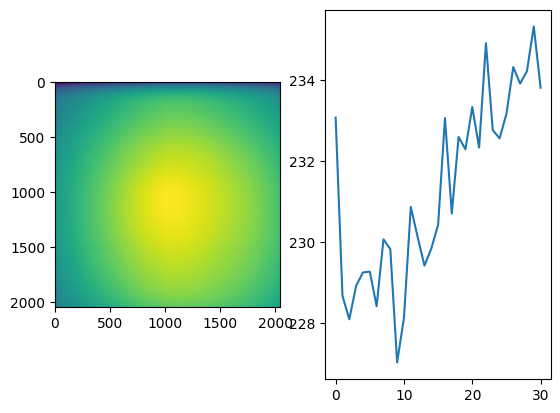

In [48]:
plt.subplot(121)
plt.imshow(b.flatfield)
plt.subplot(122)
plt.plot(b.baseline)

In [22]:
bg_val = -1
offset = 250
stacked = (
    np.ones((images.shape[-1] * 3, images.shape[-2] + images.shape[0] * offset))
    * bg_val
)
for t in range(0, images.shape[0], 10):
    transformed = affine_transform(
        images[t],
        matrix=m,
        offset=(-images.shape[-1] * 0.5 - t * offset / 2, -t * offset),
        output_shape=stacked.shape,
        cval=bg_val,
    )
    stacked[transformed != bg_val] = transformed[transformed != bg_val]

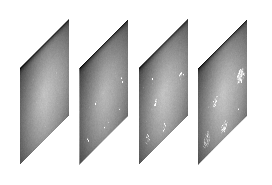

In [37]:
plt.figure(figsize=(1.5, 1.5))
stacked[stacked == bg_val] = 512
plt.imshow(stacked, vmin=150, vmax=300, cmap="gray")
plt.axis("off")
plt.savefig("plots/timelapse_before_correction.pdf", bbox_inches="tight", dpi=1000)
plt.show()

In [31]:
channel = 3
m = np.array([[0.5, 0.5], [0, 1]])

stacked_transformed = (
    np.ones((images.shape[-1] * 3, images.shape[-2] + images.shape[0] * offset))
    * bg_val
)
for t in range(0, images.shape[0], 10):
    im = images_transformed[t].copy()
    """
    im[:width,:] = 512
    im[-width:,:] = 512
    im[:,:width] = 512
    im[:,-width:] = 512"""
    transformed = affine_transform(
        im,
        matrix=m,
        offset=(-images_transformed.shape[-1] * 0.5 - t * offset / 2, -t * offset),
        output_shape=stacked_transformed.shape,
        cval=bg_val,
    )
    stacked_transformed[transformed != bg_val] = transformed[transformed != bg_val]

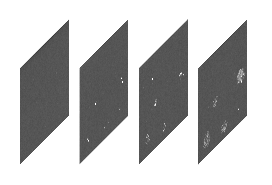

In [35]:
plt.figure(figsize=(1.5, 1.5))
stacked_transformed[stacked_transformed == bg_val] = 512
plt.imshow(stacked_transformed, vmin=-50, vmax=300 - 150 - 50, cmap="gray")
plt.axis("off")
plt.savefig("plots/timelapse_after_correction.pdf", bbox_inches="tight", dpi=1000)
plt.show()

In [49]:
bg_mean = [np.mean(im[rect]) for im in images]
bg_mean_transformed = [np.mean(im[rect]) for im in images_transformed]
fg_mean = [np.mean(im[rect2]) for im, m in zip(images, masks)]
fg_mean_transformed = [np.mean(im[rect2]) for im, m in zip(images_transformed, masks)]
plt.figure(figsize=(1.5, 1.2))
plt.plot(bg_mean)
plt.plot(fg_mean)
plt.ylim(235, 265)
plt.xlabel("Frame")
plt.ylabel("Intensity", y=0.4)
plt.subplots_adjust(left=0.4, bottom=0.5)
plt.savefig("plots/timelapse_mean_before_correction.pdf")
plt.figure(figsize=(1.5, 1.2))
plt.plot(bg_mean_transformed)
plt.plot(fg_mean_transformed)
plt.ylim(-1, 29)
plt.xlabel("Frame")
plt.ylabel("Intensity", y=0.4)
plt.subplots_adjust(left=0.4, bottom=0.5)
plt.savefig("plots/timelapse_mean_after_correction.pdf")